In [17]:
import re
from collections import namedtuple

class Tokenizer:

    Token = namedtuple('Token', 'name text span')

    def __init__(self, tokens):
        self.tokens = tokens
        pat_list = []
        for tok, pat in self.tokens:
            pat_list.append('(?P<%s>%s)' % (tok, pat))
            self.re = re.compile('|'.join(pat_list))

    def iter_tokens(self, input, ignore_ws=True):
        for match in self.re.finditer(input):
            if ignore_ws and match.lastgroup == 'WHITESPACE':
                continue
            yield Tokenizer.Token(match.lastgroup, match.group(0), match.span(0))
    
    def iter_sentences(self, input, ignore_ws=True):
        for sentence in re.compile('[.;!?] ').split(input):
            yield ('SENTENCE', list(self.iter_tokens(sentence, ignore_ws)))
            
    def tokenize(self, input, ignore_ws=True):
        return list(iter_sentences(input, ignore_ws))

# test program
if __name__ == "__main__":

    TOKENS = [
        ('NIL'        , r"nil|\'()"),
        ('TRUE'       , r'true|#t'),
        ('FALSE'      , r'false|#f'),
        ('NUMBER'     , r'\d+'),
        ('STRING'     , r'"(\\.|[^"])*"'),
        ('WORD'     , r'[A-ZĄĆĘŁŃÓŚŹŻa-ząćęłńóśźż]+'),
        ('QUOTE'      , r"'"),
        ('LPAREN'     , r'\('),
        ('RPAREN'     , r'\)'),
        ('DOT'        , r'\.'),
        ('WHITESPACE' , r'\w+'),
    ]

    for t in Tokenizer(TOKENS).iter_sentences('Linux 5.9 miał być mniejszą aktualizacją niż ostatecznie jest. Na większą liczbę nowinek nikt chyba jednak nie będzie narzekać. Szczególnie, że są to nowinki nie bez znaczenia, takie jak (dodana po ponad 5 latach prób) obsługa FSGSBASE, oznaczająca spory wzrost wydajności – zarówno w przypadku platform opartych na procesorach Intela, jak i tych, których sercami są układy AMD. Najbardziej odczujesz to w sytuacjach dużego obciążenia.'):
        print(t)

('SENTENCE', [Token(name='WORD', text='Linux', span=(0, 5)), Token(name='NUMBER', text='5', span=(6, 7)), Token(name='DOT', text='.', span=(7, 8)), Token(name='NUMBER', text='9', span=(8, 9)), Token(name='WORD', text='miał', span=(10, 14)), Token(name='WORD', text='być', span=(15, 18)), Token(name='WORD', text='mniejszą', span=(19, 27)), Token(name='WORD', text='aktualizacją', span=(28, 40)), Token(name='WORD', text='niż', span=(41, 44)), Token(name='WORD', text='ostatecznie', span=(45, 56)), Token(name='WORD', text='jest', span=(57, 61))])
('SENTENCE', [Token(name='WORD', text='Na', span=(0, 2)), Token(name='WORD', text='większą', span=(3, 10)), Token(name='WORD', text='liczbę', span=(11, 17)), Token(name='WORD', text='nowinek', span=(18, 25)), Token(name='WORD', text='nikt', span=(26, 30)), Token(name='WORD', text='chyba', span=(31, 36)), Token(name='WORD', text='jednak', span=(37, 43)), Token(name='WORD', text='nie', span=(44, 47)), Token(name='WORD', text='będzie', span=(48, 54)), 

In [18]:
import pickle
import gzip
import numpy

def load_poleval2019():
    with open('data.pkl', 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'utf-8'
        data = u.load()
    return data

In [19]:
def cardinality(data):
    return {'data': len(data)}

def class_frequencies(data):
    class_freq = {}
    for d in data:
        if d not in class_freq:
            class_freq[d] = 1
        else:
            class_freq[d] += 1
    return class_freq

def class_balance(data):
    freq = class_frequencies(data)
    total = sum([v for k, v in freq.items()])
    return {k: round(float(v)*100/total, 2) for k, v in freq.items()}

In [20]:
def visualize_quality(loader):
    data = loader()
    cls = [d[-1] for d in data]
    print('Sample data:')
    print(data[0][0])

    print('Total: {}'.format(cardinality(data[0])))
    print('Freq: {}'.format(class_frequencies(data[1])))
    print('Balance: {}'.format(class_balance(data[1])))

visualize_quality(load_poleval2019)

Sample data:
Dla mnie faworytem do tytułu będzie Cracovia. Zobaczymy, czy typ się sprawdzi.

Total: {'data': 11041}
Freq: {0: 10056, 1: 985}
Balance: {0: 91.08, 1: 8.92}


In [21]:
from twitter_preprocessor import TwitterPreprocessor
import demoji
demoji.download_codes()
def save_sentences(loader, sentences, labels):
    data = loader()
    with open(sentences, "w+") as f:
        for index, text in enumerate(data[0]):
            tweet = TwitterPreprocessor(text)
            tweet.remove_mentions().remove_urls().remove_hashtags()
            tweetText = demoji.replace(tweet.text, "")
            tweetText = tweetText.replace("\\", "")
            tweetText = tweetText.replace(":)", "")
            tweetText = tweetText.replace(";)", "")
            tweetText = tweetText.replace(":-)", "")
            tweetText = tweetText.replace(";-)", "")
            tweetText = tweetText.replace(":D", "")
            tweetText = tweetText.replace(":-D", "")
            f.write(tweetText.strip() + ' # ' + '\n')
        
    with open(labels, "w+") as f:
        for index, text in enumerate(data[1]):
            f.write(str(text) + '\n')

save_sentences(load_poleval2019, "tweets.txt", "labels.txt")

... OK (Got response in 0.30 seconds)
Writing emoji data to /home/karol/.demoji/codes.json ...
... OK


In [22]:
import xml.etree.ElementTree as ET
def write_part_of_speech(readfile, filewrite, parts_of_speech):
    tree = ET.parse(readfile)
    chunklist = tree.getroot()
    with open(filewrite, "w+") as f:
        tweet = []
        for token in chunklist.iter('tok'):
            lex = token.find('lex')
            base = lex.find('base').text
            if base == '#':
                tweetStr = ' '.join(tweet)
                f.write(tweetStr + '\n')
                tweet = []
            else:
                ctag = lex.find('ctag').text
                pos = ctag.split(':')[0]
                if pos in parts_of_speech:
                    tweet.append(base)

In [23]:
parts_of_speech = ['subst', 'depr']
write_part_of_speech("WCRFT2.xml", 'WCRFT2Rzecz.txt', parts_of_speech)

In [24]:
parts_of_speech = ['adj', 'adja', 'adjp', 'adjc']
write_part_of_speech("WCRFT2.xml", 'WCRFT2Przym.txt', parts_of_speech)

In [25]:
parts_of_speech = ['fin', 'bedzie', 'aglt', 'praet', 'impt', 'imps', 'inf', 'pcon', 'pant', 'ger', 'pact', 'ppas', 'winien']
write_part_of_speech("WCRFT2.xml", 'WCRFT2Czas.txt', parts_of_speech)

In [26]:
parts_of_speech = ['NOUN', 'PROPN']
write_part_of_speech("Spacy.xml", 'SpacyRzecz.txt', parts_of_speech)

In [27]:
parts_of_speech = ['ADJ']
write_part_of_speech("Spacy.xml", 'SpacyPrzym.txt', parts_of_speech)

In [28]:
parts_of_speech = ['VERB']
write_part_of_speech("Spacy.xml", 'SpacyCzas.txt', parts_of_speech)

In [29]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def confusion_matrix_plot(conf_mat, cls, x_label, y_label, title, file_name=None):
    plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    tick_marks = np.arange(len(cls))
    plt.grid(False)
    plt.xticks(tick_marks, cls, rotation=45)
    plt.yticks(tick_marks, cls)
    
    for i in range(len(cls)):
        for j in range(len(cls)):
            plt.text(j - 0.2, i, str(conf_mat[i][j]), fontsize=16)
    
    if file_name:
        plt.savefig(file_name)
    plt.show()

In [30]:
def test_cases_board(test_cases, title, file_name=None):
    h = 20
    n = len(test_cases)
    fig, axis = plt.subplots(1, 1, figsize=(16., n*3.2))
    axis.axis('off')
    axis.set_xlim([0, 100])
    axis.set_ylim([0, n*h])
    axis.plot([0, 100], [0, 0], color='k')
    axis.plot([0, 0], [0, n*h], color='k')
    axis.plot([100, 100], [0, n*h], color='k')
    
    for i in range(n):
        axis.annotate('Tweet text:', xy=(4, 16 + i*h),
                      xycoords='data', size=15, fontweight='bold')
        text = u'{}'.format(test_cases[i]['Text'].replace('\n', ''))
        if int(len(text)/3) != 0:
            text = '\n'.join([text[j:int(j+len(text)/3)] for j in range(0, len(text), int(len(text)/3))])
        else:
            text = '\n'.join([text[j:int(j+len(text)/3)] for j in range(0, len(text))])
        axis.annotate(text, xy=(4, 7 + i*h), xycoords='data', size=15)
        
        axis.annotate('Prediction:', xy=(4, 4 + i*h),
                      xycoords='data', size=15, fontweight='bold')
        pred = 'no hate' if test_cases[i]['Prediction'] == 0 else 'hate speech'
        pred_color = 'b' if pred == 'no hate' else 'm'
        axis.annotate(pred, xy=(15, 4 + i*h), xycoords='data', size=15, color=pred_color)
        
        axis.annotate('Label:', xy=(27, 4 + i*h),
                      xycoords='data', size=15, fontweight='bold')
        label = 'no hate' if test_cases[i]['Label'] == 0 else 'hate speech'
        label_color = 'b' if label == 'no hate' else 'm'
        axis.annotate(label, xy=(34, 4 + i*h), xycoords='data', size=15, color=label_color)
        
        axis.annotate('Result:', xy=(50, 4 + i*h),
                      xycoords='data', size=15, fontweight='bold')
        reason = 'OK' if pred == label else '1-st type error' if pred == 'no hate' else '2-nd type error'
        reason_color = 'g' if reason == 'OK' else 'r'
        axis.annotate(reason, xy=(57, 4 + i*h), xycoords='data', size=15, color=reason_color)
        
        axis.plot([0, 100], [20 + i*h, 20 + i*h], color='k')
    
    
    plt.title(title)
    if file_name:
        plt.savefig(file_name)
    plt.show()

In [31]:
from time import time

import pickle
import gzip
import pandas as pd
from sklearn.metrics import f1_score, make_scorer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

def test_classifier(text_file, out_file, board_file):
    SPLIT_RATIO = 0.7

    columns = ['tweet', 'target']
    rows = []
    with open(text_file) as texts, open("labels.txt") as labels:
        for text, label in zip(texts, labels):
            rows.append([text.rstrip('\n'), label.rstrip('\n')])

    data = pd.DataFrame(rows, columns=columns)

    categories = ['0', '1']

    print(categories)
    pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', ComplementNB(fit_prior=True, class_prior=None)),
    ])
    parameters = {
        'vect__max_df': (0.5, 0.75, 1.0, 1.5, 1.75),
        'vect__max_features': (None, 5000, 10000, 50000),
        'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1,4), (1,5), (1,6), (1,10)),  # unigrams or bigrams
        'tfidf__use_idf': (True, False),
        'tfidf__norm': ('l1', 'l2'),
        'clf__alpha': (0.3, 0.6, 1.0)
    }
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='f1_micro')
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time()
    grid_search.fit(list(data.tweet), list(data.target))
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    predictions = grid_search.predict(list(data.tweet))
    matrix = confusion_matrix(list(data.target), list(predictions))
    confusion_matrix_plot(matrix, cls=['no hate', 'hate speech'], x_label='Real', y_label='Predicted',
                      title='confusion matrix',
                      file_name=out_file)

    texts = list(data.tweet)
    new_texts = texts
    labels = list(data.target)

    new_texts = new_texts[int(SPLIT_RATIO*len(texts)):]
    new_targets = list(labels)[int(SPLIT_RATIO*len(texts)):]
    new_predictions = list(predictions)[int(SPLIT_RATIO*len(texts)):]

    indices = [6, 10, 19, 26, 27, 28, 29, 164]
    test_cases = []
    for i, (t, p, l) in enumerate(zip(new_texts, new_predictions, new_targets)):
        if i in indices:
            test_cases.append({'Text': t, 'Prediction': p, 'Label': l})
    
    test_cases_board(test_cases, title='Tweets summary', file_name=board_file)

['0', '1']
Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__max_df': (0.5, 0.75, 1.0, 1.5, 1.75), 'vect__max_features': (None, 5000, 10000, 50000), 'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 10)), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__alpha': (0.3, 0.6, 1.0)}
Fitting 5 folds for each of 1680 candidates, totalling 8400 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:   57.3s
[Para

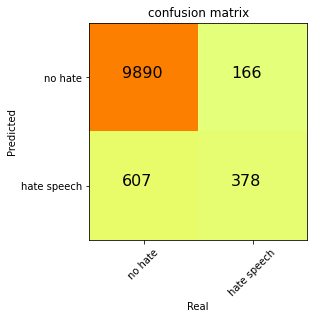

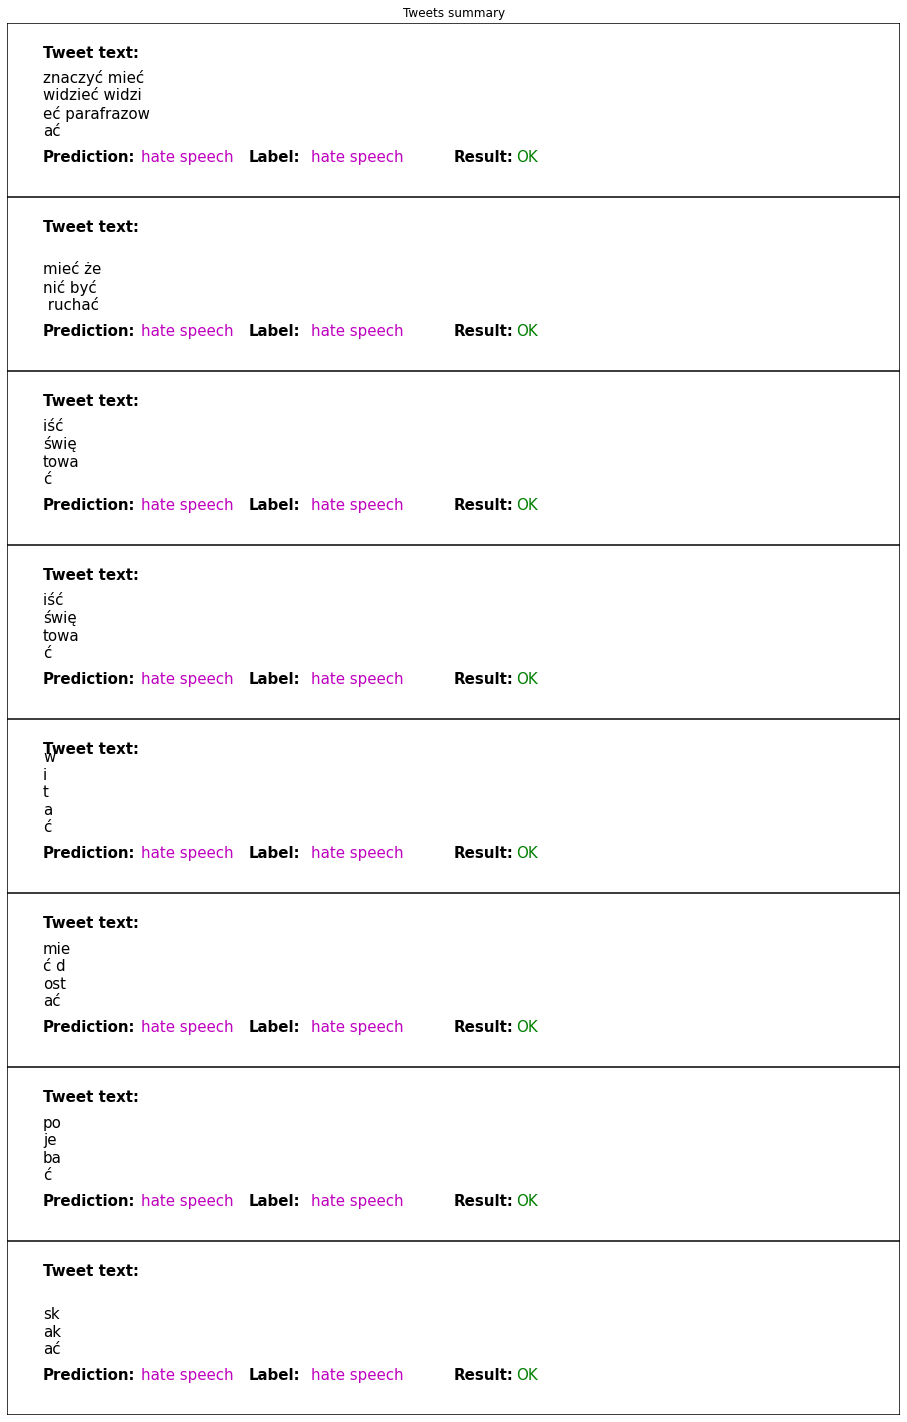

In [32]:
test_classifier("MorphoDitaCzas.txt", "images/MorphoDitaCzas.png", "images/MorphoDitaCzasBoard.png")

['0', '1']
Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__max_df': (0.5, 0.75, 1.0, 1.5, 1.75), 'vect__max_features': (None, 5000, 10000, 50000), 'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 10)), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__alpha': (0.3, 0.6, 1.0)}
Fitting 5 folds for each of 1680 candidates, totalling 8400 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done 4828 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:  1.7min
[Par

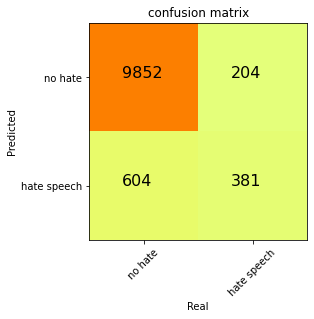

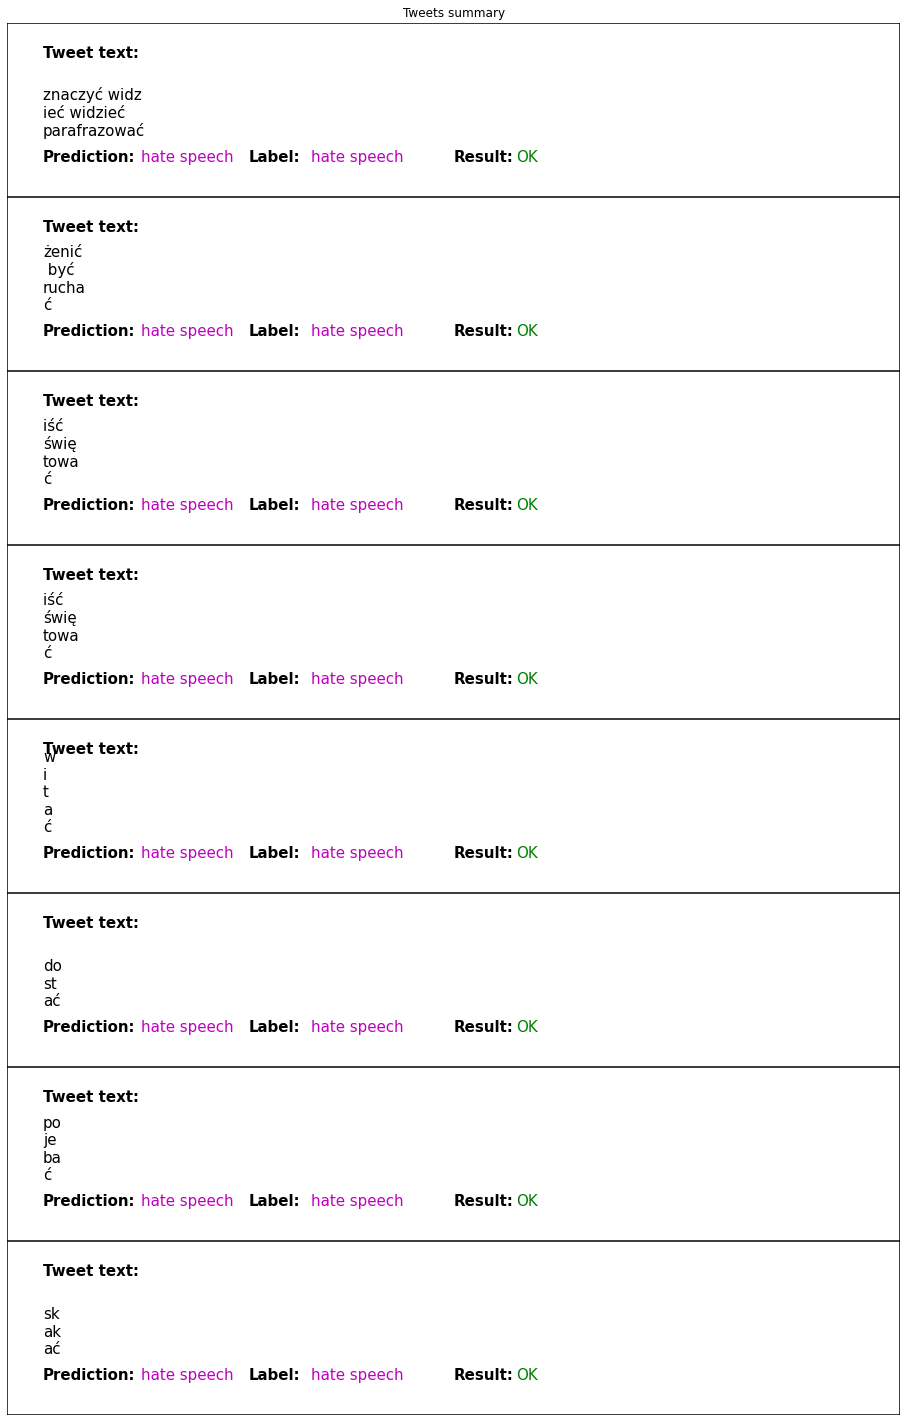

In [33]:
test_classifier("WCRFT2Czas.txt", "images/WCRFT2Czas.png", "images/WCRFT2CzasBoard.png")

['0', '1']
Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__max_df': (0.5, 0.75, 1.0, 1.5, 1.75), 'vect__max_features': (None, 5000, 10000, 50000), 'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 10)), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__alpha': (0.3, 0.6, 1.0)}
Fitting 5 folds for each of 1680 candidates, totalling 8400 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4828 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:  1.9min
[Par

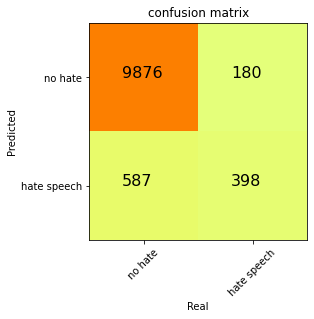

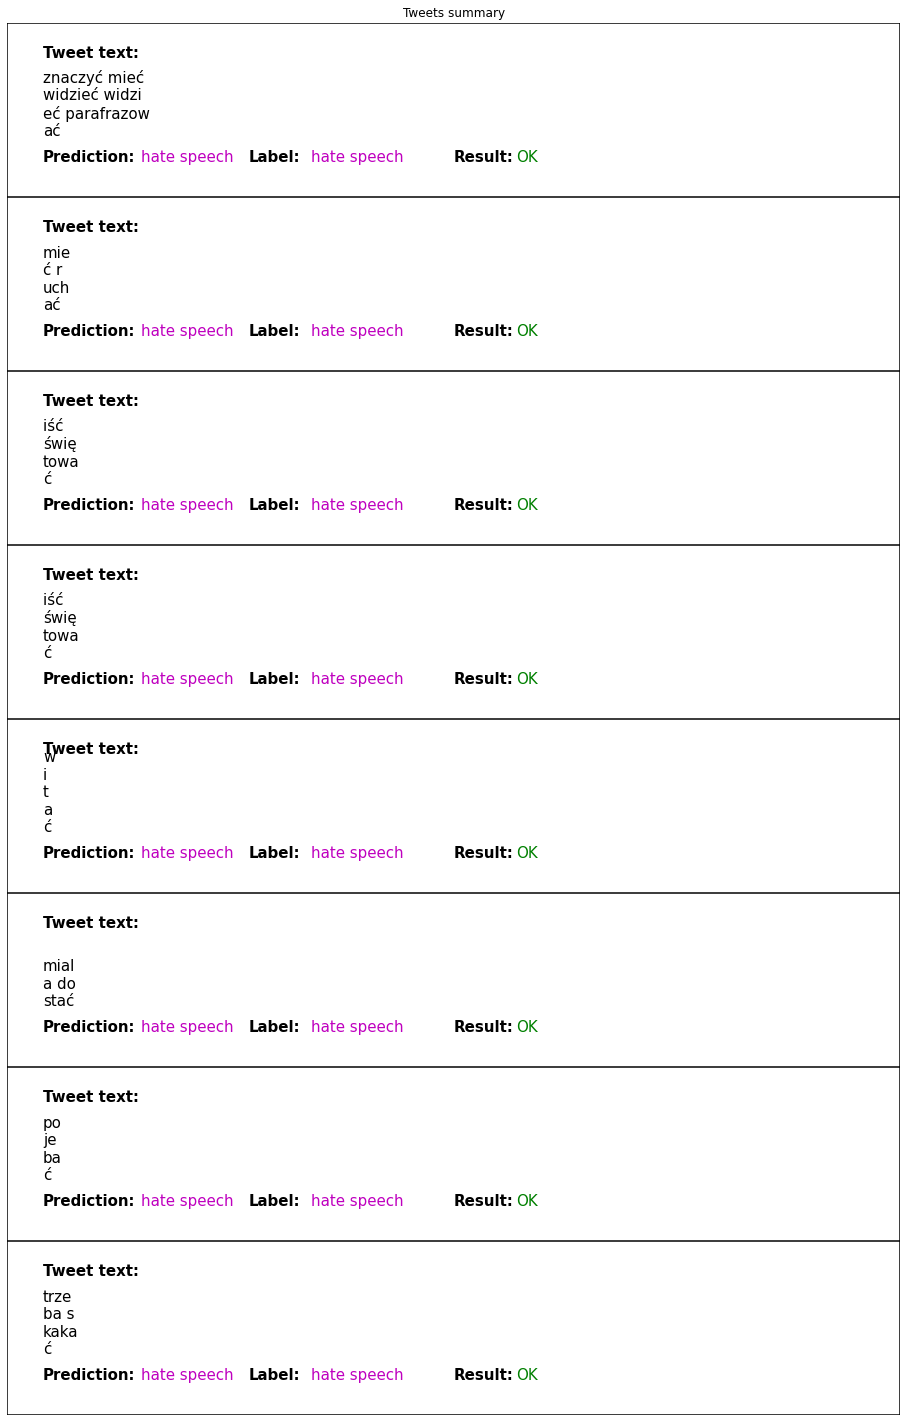

In [34]:
test_classifier("SpacyCzas.txt", "images/SpacyCzas.png", "images/SpacyCzasBoard.png")

['0', '1']
Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__max_df': (0.5, 0.75, 1.0, 1.5, 1.75), 'vect__max_features': (None, 5000, 10000, 50000), 'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 10)), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__alpha': (0.3, 0.6, 1.0)}
Fitting 5 folds for each of 1680 candidates, totalling 8400 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 4828 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:  1.2min
[Par

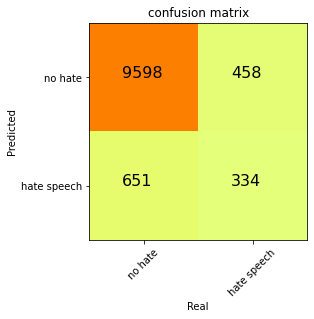

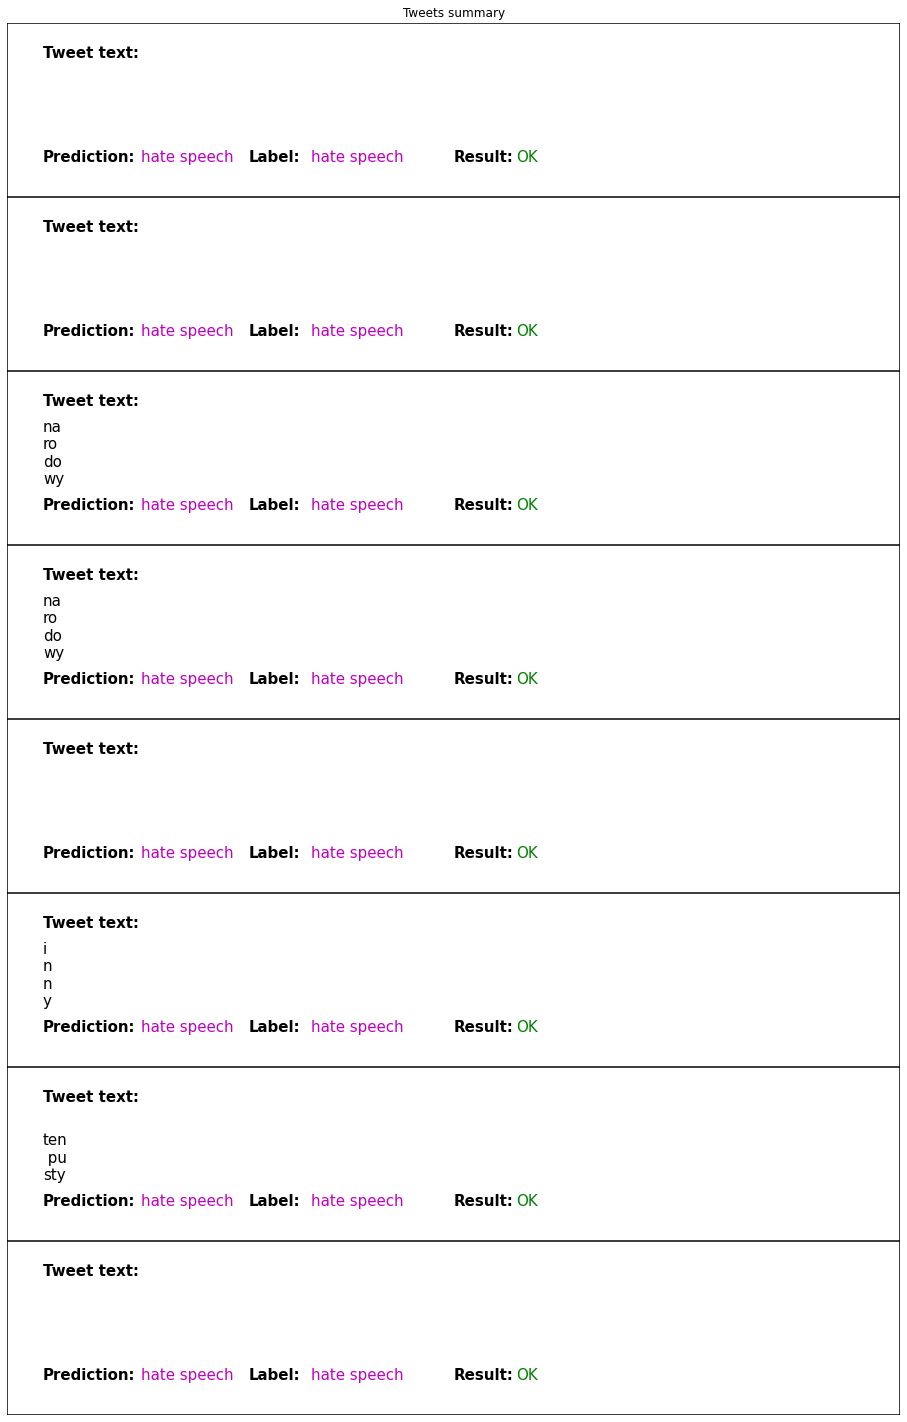

In [35]:
test_classifier("MorphoDitaPrzym.txt", "images/MorphoDitaPrzym.png", "images/MorphoDitaPrzymBoard.png")

['0', '1']
Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__max_df': (0.5, 0.75, 1.0, 1.5, 1.75), 'vect__max_features': (None, 5000, 10000, 50000), 'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 10)), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__alpha': (0.3, 0.6, 1.0)}
Fitting 5 folds for each of 1680 candidates, totalling 8400 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 4828 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:  1.0min
[Par

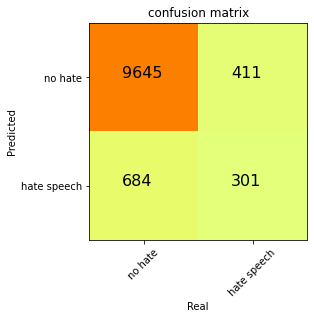

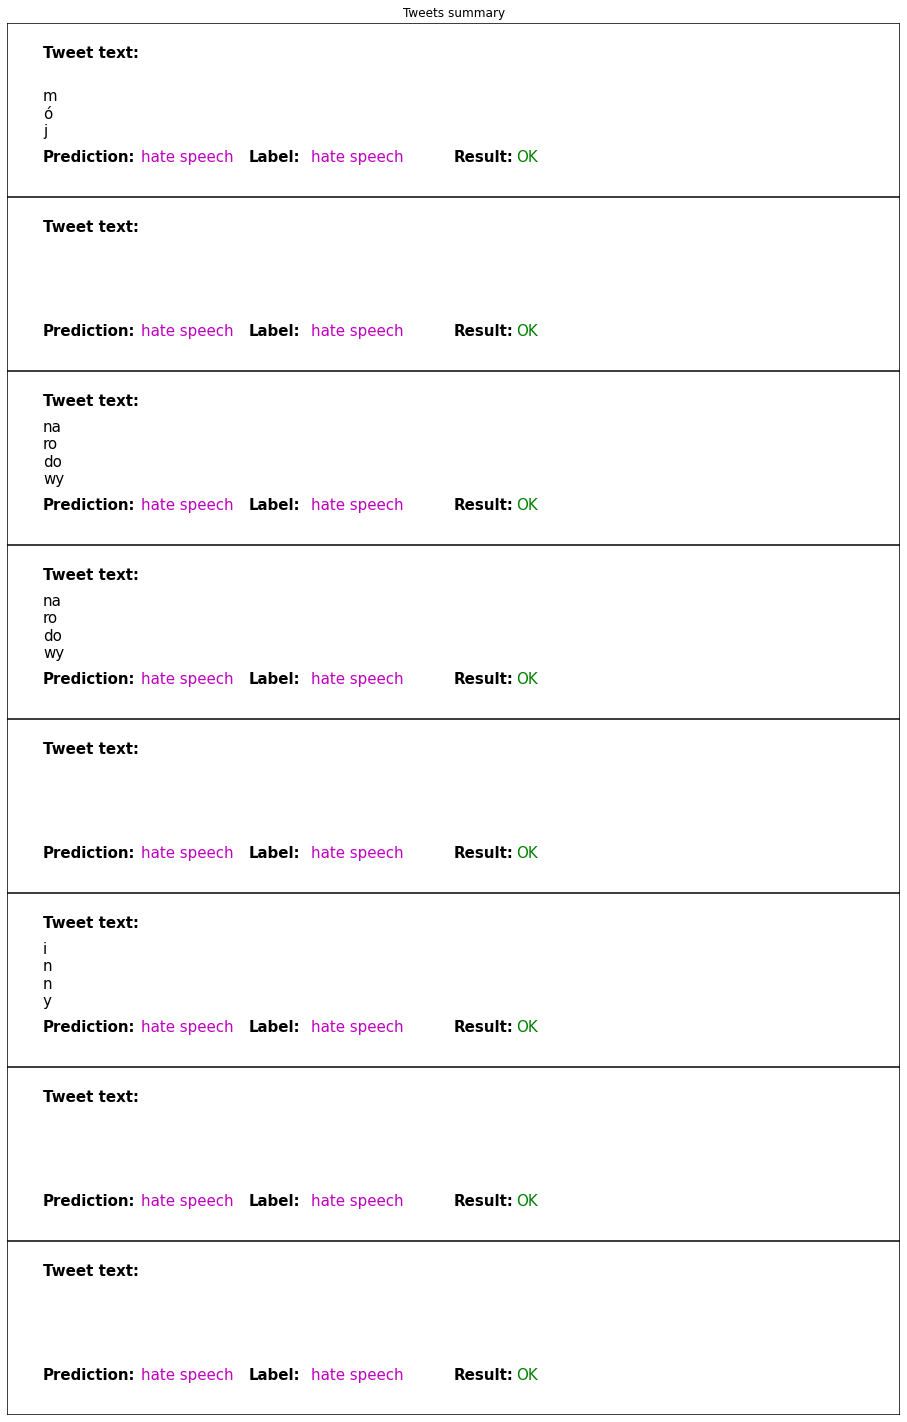

In [36]:
test_classifier("WCRFT2Przym.txt", "images/WCRFT2Przym.png", "images/MorphoDitaPrzymBoard.png")

['0', '1']
Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__max_df': (0.5, 0.75, 1.0, 1.5, 1.75), 'vect__max_features': (None, 5000, 10000, 50000), 'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 10)), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__alpha': (0.3, 0.6, 1.0)}
Fitting 5 folds for each of 1680 candidates, totalling 8400 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 4828 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:  1.2min
[Par

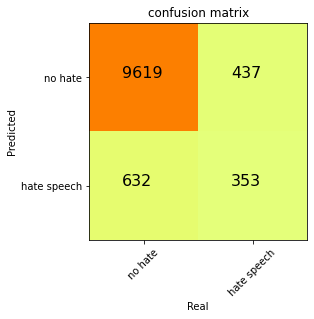

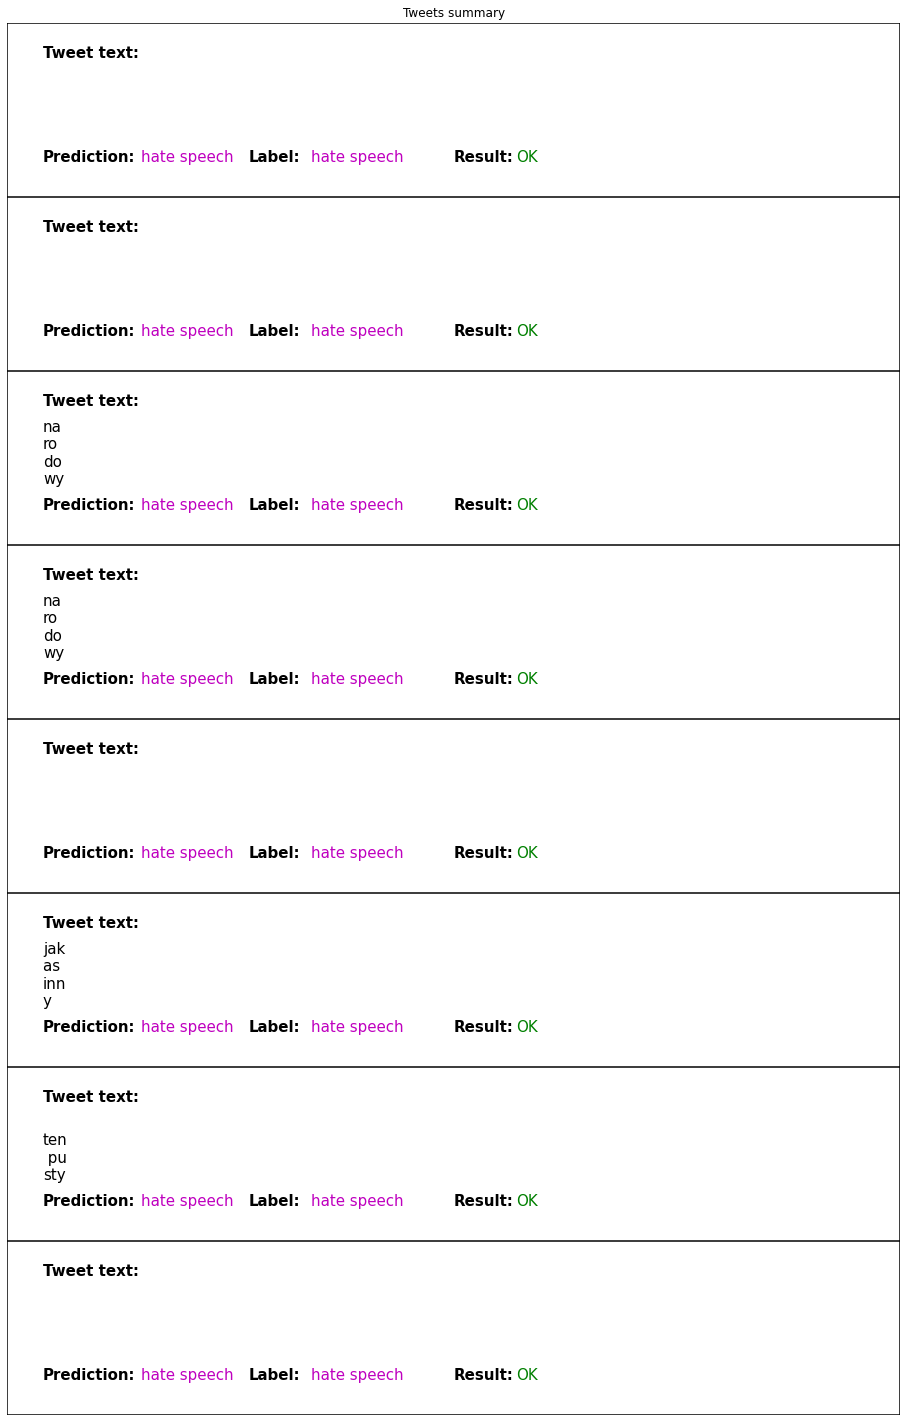

In [37]:
test_classifier("SpacyPrzym.txt", "images/SpacyPrzym.png", "images/SpacyPrzymBoard.png")

['0', '1']
Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__max_df': (0.5, 0.75, 1.0, 1.5, 1.75), 'vect__max_features': (None, 5000, 10000, 50000), 'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 10)), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__alpha': (0.3, 0.6, 1.0)}
Fitting 5 folds for each of 1680 candidates, totalling 8400 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4828 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:  2.9min
[Par

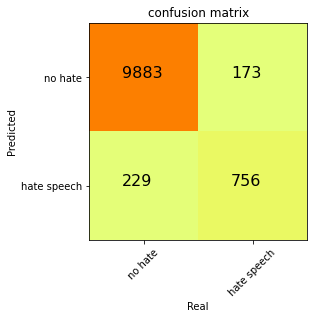

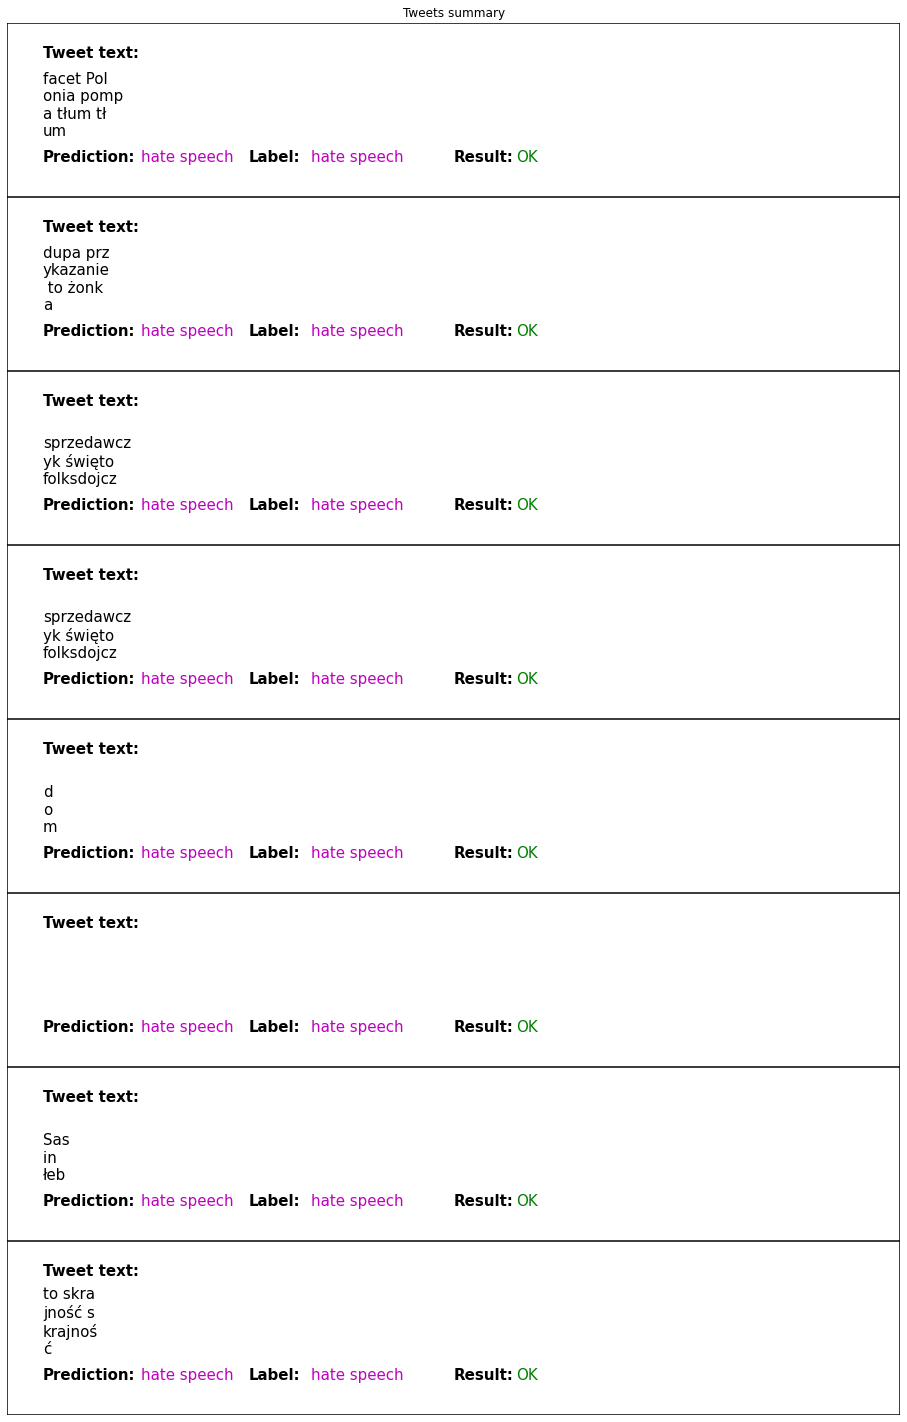

In [38]:
test_classifier("MorphoDitaRzecz.txt", "images/MorphoDitaRzecz.png", "images/MorphoDitaRzeczBoard.png")

['0', '1']
Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__max_df': (0.5, 0.75, 1.0, 1.5, 1.75), 'vect__max_features': (None, 5000, 10000, 50000), 'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 10)), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__alpha': (0.3, 0.6, 1.0)}
Fitting 5 folds for each of 1680 candidates, totalling 8400 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4828 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:  3.2min
[Par

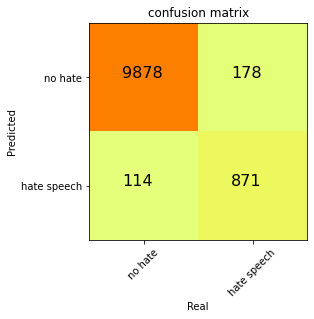

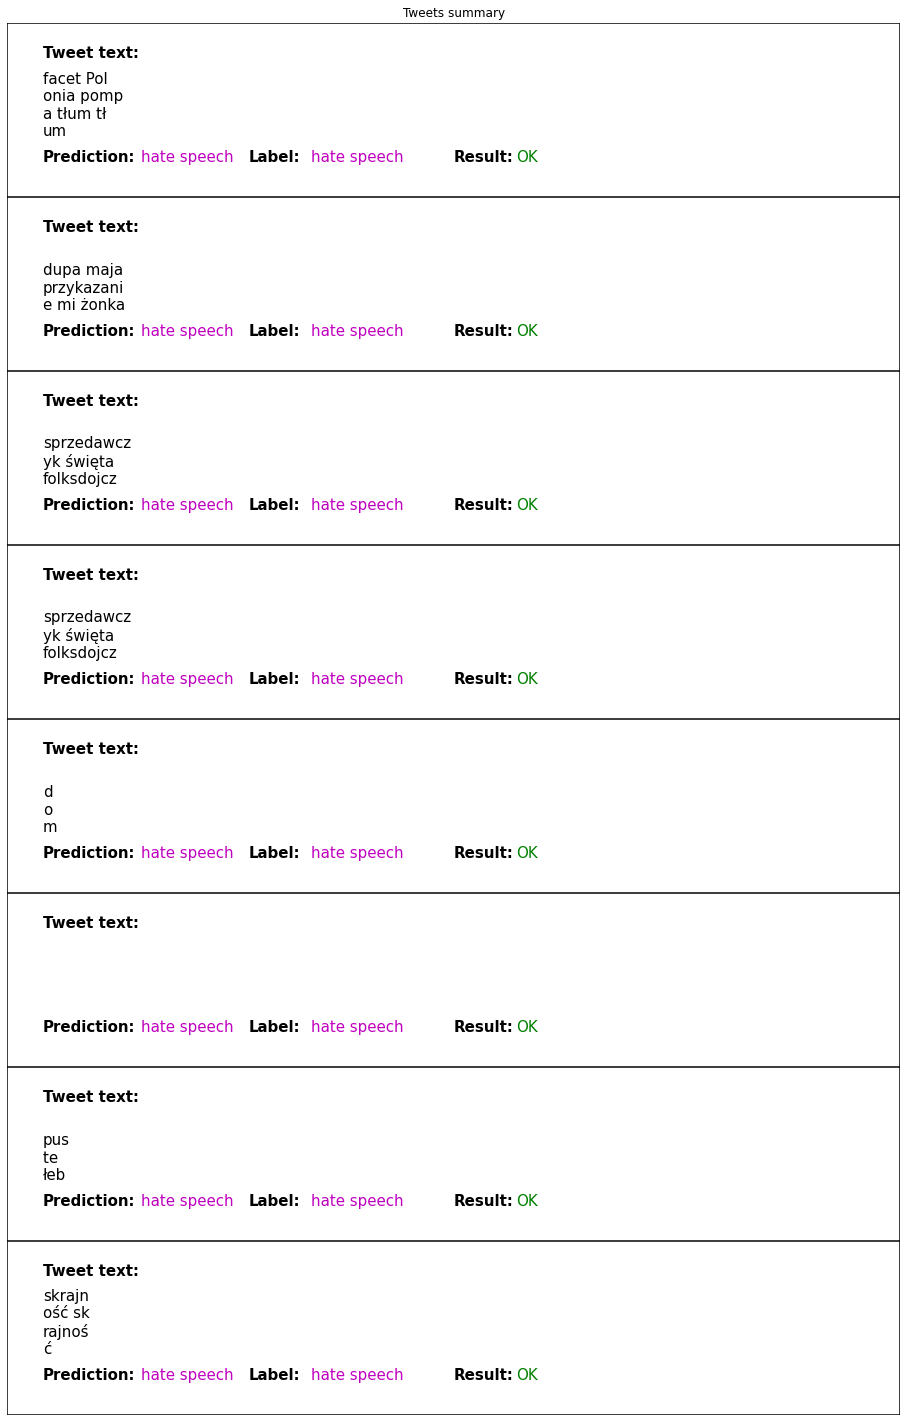

In [39]:
test_classifier("WCRFT2Rzecz.txt", "images/WCRFT2Rzecz.png", "images/WCRFT2RzeczBoard.png")

['0', '1']
Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__max_df': (0.5, 0.75, 1.0, 1.5, 1.75), 'vect__max_features': (None, 5000, 10000, 50000), 'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 10)), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__alpha': (0.3, 0.6, 1.0)}
Fitting 5 folds for each of 1680 candidates, totalling 8400 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 4828 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:  3.6min
[Par

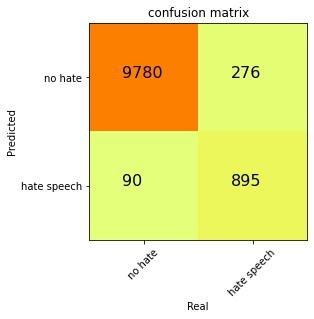

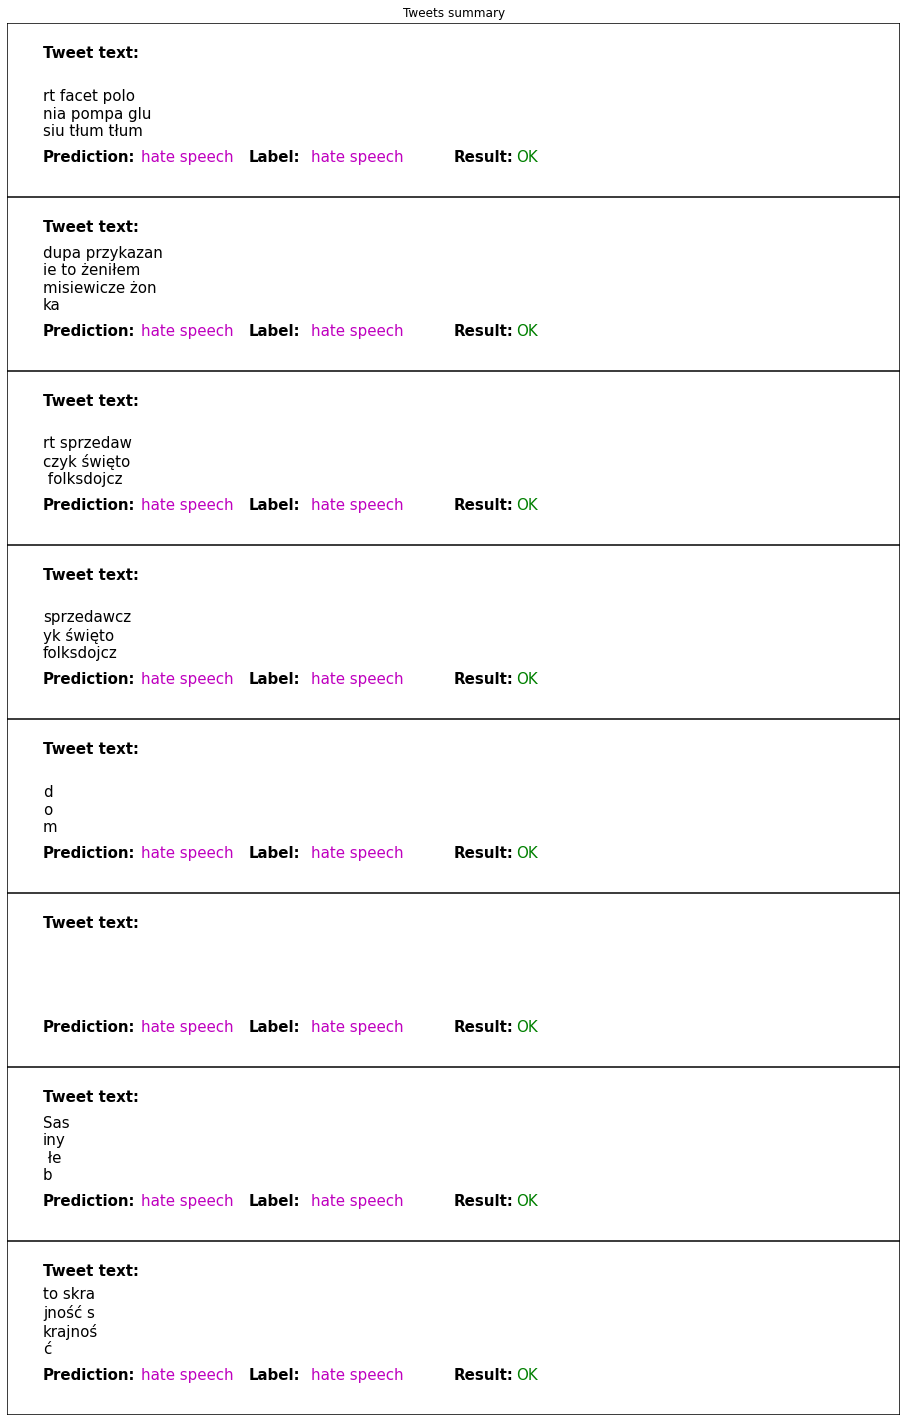

In [40]:
test_classifier("SpacyRzecz.txt", "images/SpacyRzecz.png", "images/SpacyRzeczBoard.png")

['0', '1']
Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__max_df': (0.5, 0.75, 1.0, 1.5, 1.75), 'vect__max_features': (None, 5000, 10000, 50000), 'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 10)), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__alpha': (0.3, 0.6, 1.0)}
Fitting 5 folds for each of 1680 candidates, totalling 8400 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  7.5min
[Para

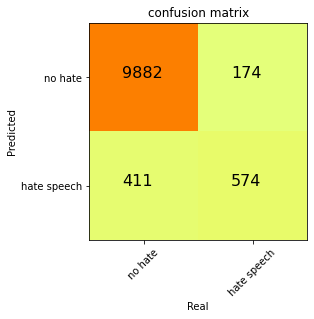

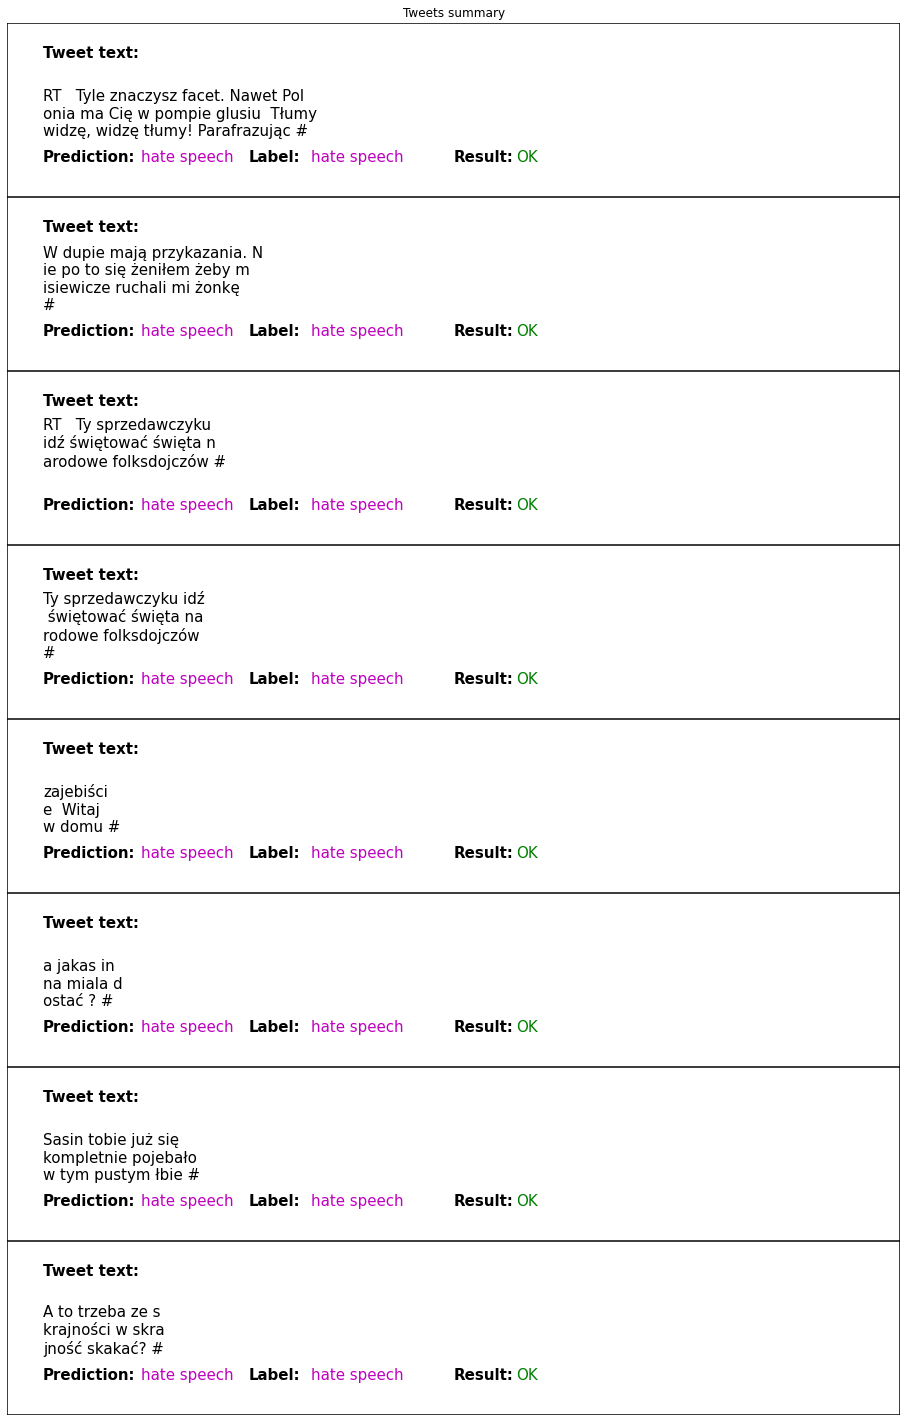

In [41]:
test_classifier("tweets.txt", "images/tweets.png", "images/tweetsBoard.png")